In [48]:
import pandas as pd
import psycopg2 as pg2
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, roc_curve
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.under_sampling import RandomUnderSampler
import numpy as np



In [17]:
conn = pg2.connect(user='postgres',  dbname='penny', host='localhost', port='5432', password='password')
df = pd.read_sql ("""Select * LIMIT (1000000) from auction_full """, conn)
df_backup = df.copy()

In [12]:
df = df_backup.copy()

In [18]:
df.is_bidomatic0 = df.is_bidomatic0.astype(str)
df.is_bidomatic1 = df.is_bidomatic1.astype(str)
df.is_bidomatic2 = df.is_bidomatic2.astype(str)
df.is_bidomatic3 = df.is_bidomatic3.astype(str)


In [19]:


y = df.pop('is_winner')
X = df
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=234234) 


In [23]:
y_train.sum()

14332

In [24]:
rus = RandomUnderSampler(random_state=0)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

#winner_count = sum(y_train)
#loser_mask = y_train==False
#y_train_losers = y_train[y_train==False].sample(n=winner_count)
#print(y_train_losers)
#X_train_winners = df[y_train==True]
#df_sample = pd.concat([df_losers, df_winners], axis=0)

In [29]:
X_train_resampled.shape
y_train_resampled.sum()

14332

In [30]:
categorical_features = ['cardtype', 'limited_allowed', 'is_locked', 'is_bidomatic', 'is_bidomatic0', 'is_bidomatic1', 'is_bidomatic2', 'is_bidomatic3' ]
numeric_features = ['cashvalue','bidvalue', 'bid', 'prevusers', 
                     'bids_so_far0', 'streak0', 
                    'distance1', 'bids_so_far1', 'streak1',
                    'distance2', 'bids_so_far2', 'streak2',
                    'distance3', 'bids_so_far3', 'streak3']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-1)),
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='error'))])   #,   drop='first'))])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])


In [32]:
model.fit(X_train_resampled, y_train_resampled)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=-1,
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                             

In [33]:
y_pred = model.predict(X_test)

In [34]:
cm = confusion_matrix(y_test, y_pred)
print ("Accuracy {}: Precision: {}  Recall:{} ".format(accuracy_score(y_test, y_pred), precision_score(y_test, y_pred), recall_score(y_test, y_pred)))
model.score(X_test, y_test)


Accuracy 0.7330852808483712: Precision: 0.008685921490460012  Recall:0.6944086021505377 


0.7330852808483712

In [36]:
y_test.sum()/len(y_test)

0.0033549856168519844

In [37]:
y_pred.sum()

371751

In [40]:
y_pred.shape

(1385997,)

In [42]:
print(cm)

[[1012825  368522]
 [   1421    3229]]


In [43]:
y_test.sum()

4650

In [44]:
model.steps[1][1].feature_importances_

array([0.06199217, 0.02285938, 0.07704988, 0.04052104, 0.00015103,
       0.08111108, 0.07040184, 0.07329609, 0.04954375, 0.04628864,
       0.06057311, 0.04060422, 0.03746906, 0.05082229, 0.03486334,
       0.03166779, 0.01089731, 0.00710219, 0.0063569 , 0.00840274,
       0.00386456, 0.00830918, 0.00827154, 0.00773377, 0.00455536,
       0.00467159, 0.0087514 , 0.00913713, 0.03843995, 0.00013846,
       0.04166965, 0.00972268, 0.00071922, 0.01135164, 0.00722947,
       0.00195925, 0.00694511, 0.00624499, 0.00270577, 0.00560543])

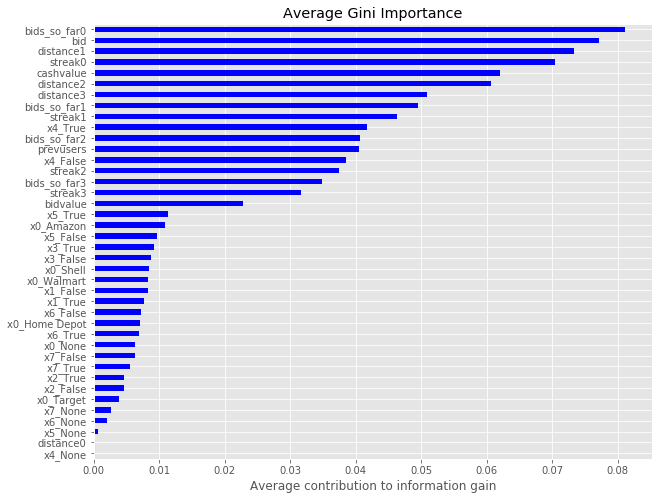

In [49]:
# Plot the feature importance
feat_scores = pd.Series(model.steps[1][1].feature_importances_,
                           index=get_column_names_from_ColumnTransformer(model.named_steps['preprocessor']))
feat_scores = feat_scores.sort_values()
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,8),
                      color='b')
ax.set_title('Average Gini Importance')
ax.set_xlabel('Average contribution to information gain');

In [46]:
def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_[:-1]:#the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
    return col_name

In [51]:
transformed_X_test = model[1][1].transform(X_test)

AttributeError: 'DecisionTreeClassifier' object has no attribute 'transform'